In [2]:
conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


In [ ]:
!git clone https://huggingface.co/datasets/cedr

In [332]:
import torch
import transformers
import torch.nn as nn
import datetime
import json
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import defaultdict
from datasets import load_dataset
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

warnings.filterwarnings("ignore", category=DeprecationWarning)

plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams['font.size'] = 12

device = torch.device('cpu')

## Описание модели классификатора на основе BERT

In [2]:
class BERT(nn.Module):
    def __init__(self, bert):
        super(BERT, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,2)
        self.softmax = nn.LogSoftmax(dim = 1)
    
    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask = mask, return_dict = False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

## Получение данных
Emotion label codes: {0: "joy", 1: "sadness", 2: "surprise", 3: "fear", 4: "anger"}


In [3]:
users_posts_part_1 = json.load(open('users_posts_part_1.json'))
users_posts_part_2 = json.load(open('users_posts_part_2.json'))

In [4]:
dataset = load_dataset("cedr")

No config specified, defaulting to: cedr/main
Found cached dataset cedr (C:/Users/Danila/.cache/huggingface/datasets/cedr/main/0.1.1/117570489cbabbdf8de619bd31918a1cd680a7f286b89d04af340d0691dc2d66)


  0%|          | 0/2 [00:00<?, ?it/s]

In [388]:
data = []
for user_id, items in users_posts_part_1.items():
    for item in items:
        data.append((user_id, item['date'], item['text']))

In [63]:
df = pd.DataFrame(data, columns=['u_id', 'date', 'text'])
df['quarter'] = df['date'].apply(lambda x: int(datetime.date.fromtimestamp(x).month / 4) + 1)

In [64]:
df

,u_id,date,text,quarter
0,1,1525805964,"Иногда говорят, что Telegram был заблокирован ...",2
1,1,1525352753,"Михаил Светов, организатор прошедшего митинга ...",2
2,1,1525187997,,2
3,1,1525168885,"Наблюдаю, как несмотря на проливной дождь, по ...",2
4,1,1525107823,"Потрясающая акция в Москве. Более 12,000 челов...",2
...,...,...,...,...
25397,566,1521891237,,1
25398,566,1521788147,С добрым утром 😊,1
25399,566,1521753210,,1
25400,566,1521526008,#утро,1


## Импорт предобученной модели BERT
https://huggingface.co/DeepPavlov/rubert-base-cased/tree/main

In [8]:
bert = AutoModel.from_pretrained('rubert-base-cased/')

## Заморозка слоев модели BERT
for param in bert.parameters():
    param.requires_grad = False

tokenizer = BertTokenizer.from_pretrained('rubert-base-cased/')

Some weights of the model checkpoint at rubert-base-cased/ were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
dataset = load_dataset("cedr")

train_cedr_df = pd.DataFrame()
train_cedr_df['text'] = [t.as_py() for t in dataset['train'].data['text']]
train_cedr_df['label'] = [v[0].as_py() if len(v) > 0 else np.nan for v in list(dataset['train'].data['labels'])]
train_cedr_df['label'] = train_cedr_df['label'].apply(lambda x: 1 if x == 0 else 0)
train_cedr_df = train_cedr_df.dropna()

test_cedr_df = pd.DataFrame()
test_cedr_df['text'] = [t.as_py() for t in dataset['test'].data['text']]
test_cedr_df['label'] = [v[0].as_py() if len(v) > 0 else np.nan for v in list(dataset['test'].data['labels'])]
test_cedr_df['label'] = test_cedr_df['label'].apply(lambda x: 1 if x == 0 else 0)
test_cedr_df = test_cedr_df.dropna()

No config specified, defaulting to: cedr/main
Found cached dataset cedr (C:/Users/Danila/.cache/huggingface/datasets/cedr/main/0.1.1/117570489cbabbdf8de619bd31918a1cd680a7f286b89d04af340d0691dc2d66)


  0%|          | 0/2 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'Распределение длины текста'}, xlabel='Длина текста', ylabel='Количество таких текстов'>

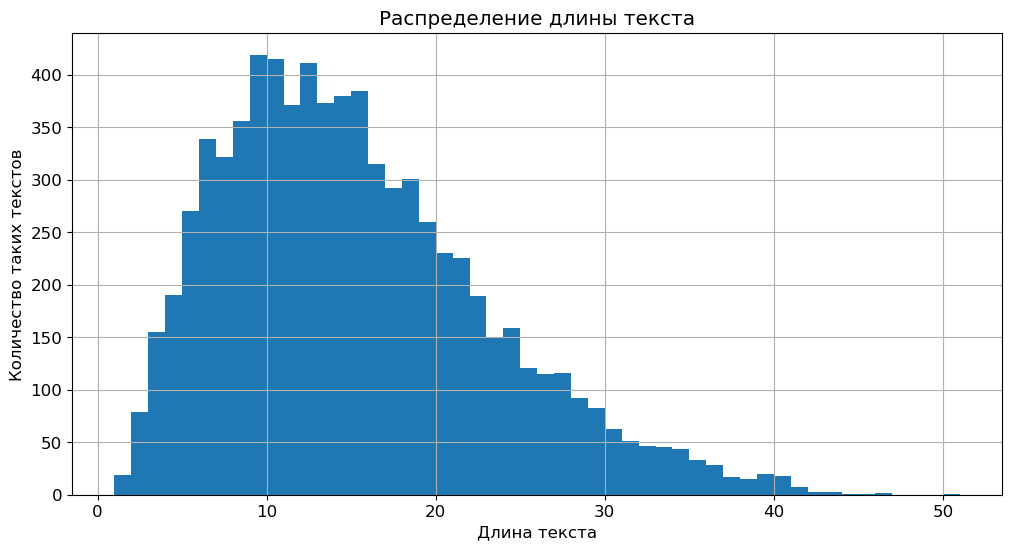

In [37]:
plt.title('Распределение длины текста')
plt.xlabel('Длина текста')
plt.ylabel('Количество таких текстов')

## На основе распределения можно выбрать 20 токенов для того, чтоб избежать разряженности вектора
pd.Series([len(str(i).split()) for i in train_cedr_df['text']]).hist(bins = 50)

## Токенизация

In [38]:
tokens_train = tokenizer.batch_encode_plus(
    train_cedr_df['text'],
    max_length = 18,
    padding = 'max_length',
    truncation = True
)

tokens_test = tokenizer.batch_encode_plus(
    test_cedr_df['text'],
    max_length = 18,
    padding = 'max_length',
    truncation = True
)

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_cedr_df['label'].values)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_cedr_df['label'].values)

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

## Инициализация модели

In [56]:
model = BERT(bert)

model = model.to(device)
optimizer = AdamW(model.parameters(), lr = 0.01)

cross_entropy = nn.CrossEntropyLoss()
batch_size = 1000
epochs = 200

In [59]:
model.train()
total_loss = 0
total_preds = []
    
for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch
    model.zero_grad()
    preds = model(sent_id, mask)
    loss = cross_entropy(preds, labels.long())
    total_loss += loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    preds = preds.detach().cpu().numpy()
    total_preds.append(preds)
        
avg_loss = total_loss / len(train_dataloader)
total_preds = np.concatenate(total_preds, axis = 0)

print(f'avg_loss: {avg_loss}')


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:27<00:00, 10.98s/it]

avg_loss: 1.3967442959547043


## Предсказание на тестовых данных

In [69]:
list_seq = np.array_split(test_seq, 18)
list_mask = np.array_split(test_mask, 18)

predictions = []
for num, elem in enumerate(list_seq):
    with torch.no_grad():
        preds = model(elem.to(device), list_mask[num].to(device))
        predictions.append(preds.detach().cpu().numpy())
        
predictions = [item[1] for sublist in predictions for item in sublist]
predictions = (predictions - min(predictions)) / (max(predictions) - min(predictions))
predictions = [1 if p > 0.90 else 0 for p in predictions]

In [70]:
print(classification_report(test_cedr_df['label'], predictions))

              precision    recall  f1-score   support

           0       0.81      0.49      0.61      1535
           1       0.18      0.50      0.27       347

    accuracy                           0.49      1882
   macro avg       0.50      0.49      0.44      1882
weighted avg       0.70      0.49      0.55      1882



## Составление психометрического профиля пользователей

### Предикт эмоциональной окраски комментариев для пользователей из вк
### В статике: по всем постам

In [131]:
df = df[df['text'] != '']

vk_tokens_test = tokenizer.batch_encode_plus(
    df['text'],
    max_length = 18,
    padding = 'max_length',
    truncation = True
)

vk_test_seq = torch.tensor(vk_tokens_test['input_ids'])
vk_test_mask = torch.tensor(vk_tokens_test['attention_mask'])

vk_list_seq = np.array_split(vk_test_seq, 18)
vk_list_mask = np.array_split(vk_test_mask, 18)

vk_raw_predictions_probs = []
for num, elem in enumerate(vk_list_seq):
    with torch.no_grad():
        prob = model(elem.to(device), vk_list_mask[num].to(device))
        vk_raw_predictions_probs.append(prob.detach().cpu().numpy())

In [132]:
vk_predictions_raw = [item[1] for sublist in vk_raw_predictions_probs for item in sublist]
vk_predictions = (vk_predictions_raw - min(vk_predictions_raw)) / (max(vk_predictions_raw) - min(vk_predictions_raw))
vk_predictions = [1 if p > 0.90 else 0 for p in vk_predictions]

In [222]:
vk_df = df.copy()
vk_df['vk_test_seq'] = vk_tokens_test['input_ids']
vk_df['prediction'] = vk_predictions

In [223]:
user_tokens = {}
user_predicts = {}
for uid in vk_df['u_id'].unique():
    sab_df = vk_df[vk_df['u_id'] == uid]
    user_tokens[uid] = np.hstack(sab_df['vk_test_seq'].values)
    user_predicts[uid] = dict(sab_df['prediction'].value_counts())

In [193]:
max_len_token = max([len(v) for v  in user_tokens.values()])
for uid, tokens in user_tokens.items():
    user_tokens[uid] = np.array(list(tokens) + list(np.zeros(max_len_token - len(tokens))))

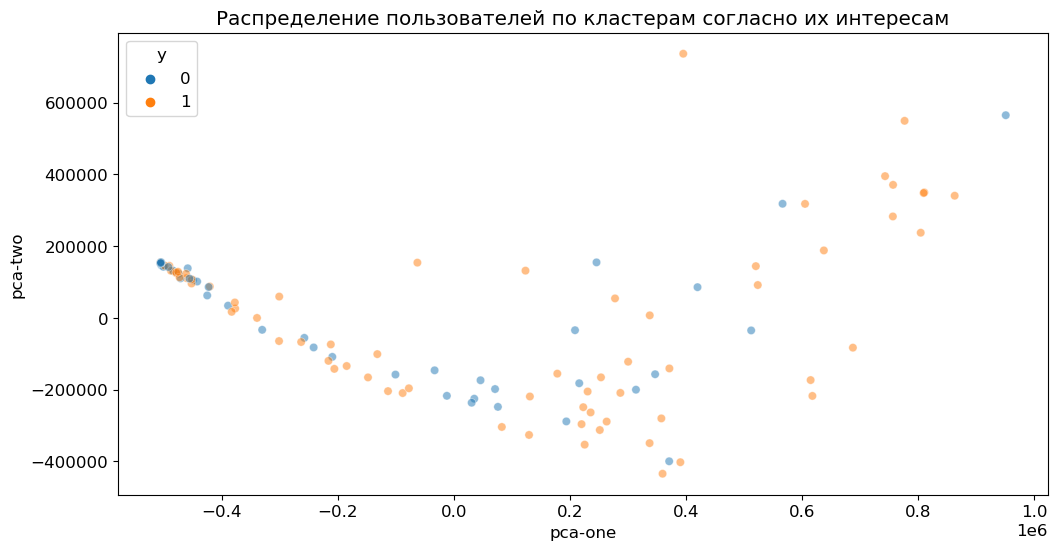

In [196]:
## Снижение размерности
pca = PCA(n_components=2)
pca_result = pca.fit_transform(list(user_tokens.values())) 

test_df = pd.DataFrame()
test_df['pca-one'] = pca_result[:,0]
test_df['pca-two'] = pca_result[:,1] 
test_df['y'] = list(user_predicts.values())

## Отрисовка графиков
fig, ax1 = plt.subplots(1)

ax1.set_title('Распределение пользователей по кластерам согласно их интересам')
ax1 = sns.scatterplot(
    ax=ax1,
    x="pca-one", y="pca-two",
    hue="y",
    data=test_df,
    legend="full",
    alpha=0.5
)

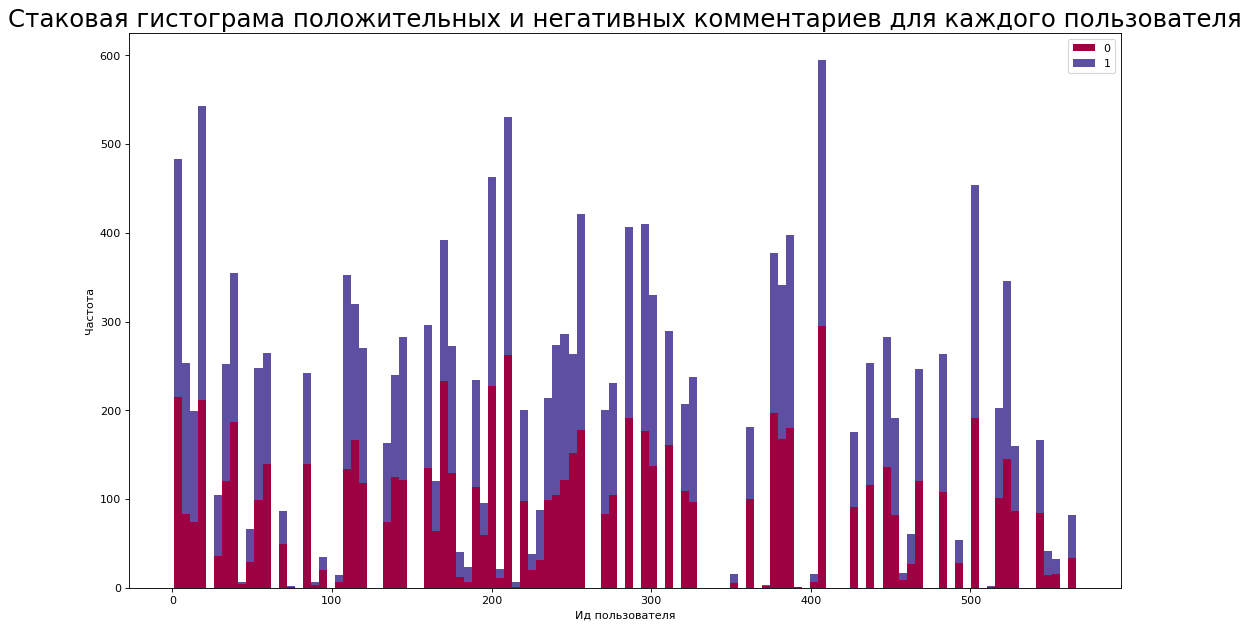

In [386]:
grouped_data = defaultdict(list)
for u_id, v in user_predicts.items():
    grouped_data[0] += [int(u_id)] * v.get(0, 0)
    grouped_data[1] += [int(u_id)] * v.get(1, 0)
    
vals = [v for v in grouped_data.values()]

plt.figure(figsize=(16,9), dpi= 80)
colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
n, bins, patches = plt.hist(vals, len(user_predicts.keys()), stacked=True, density=False, color=colors[:len(vals)])

plt.legend({group:col for group, col in zip([0, 1], colors[:len(vals)])})
plt.title(f"Стаковая гистограма положительных и негативных комментариев для каждого пользователя", fontsize=22)
plt.xlabel("Ид пользователя")
plt.ylabel("Частота");

### Предикт эмоциональной окраски комментариев для пользователей из вк
### В динамике: по годовым интервалам

In [382]:
quarter = [1, 2, 3, 4]

result = []
for u_id in vk_df['u_id'].unique():
    sub_df_1 = vk_df[vk_df['u_id'] == u_id]
    q_line = []
    for q in quarter:
        sub_df_2 = sub_df_1[sub_df_1['quarter'] == q]
        sub_dict_2 = dict(sub_df_2['prediction'].value_counts(normalize=True))
        under_line_value = sub_dict_2.get(1, 0) + sub_dict_2.get(0, 0)
        q_line.append(round(sub_dict_2.get(1, 0) / under_line_value if under_line_value > 0 else 1, 2))
        
    result.append(q_line)
    
dif_matrix = pd.DataFrame(result, columns=['q_1', 'q_2', 'q_3', 'q_4'], index=vk_df['u_id'].unique())

In [383]:
dif_matrix

,q_1,q_2,q_3,q_4
1,0.52,0.62,0.58,0.57
5,0.54,0.53,0.49,0.75
8,1.00,1.00,0.50,1.00
11,0.63,0.73,0.69,0.69
14,0.72,0.61,0.59,0.67
...,...,...,...,...
547,0.82,0.67,0.50,0.00
550,1.00,0.75,0.38,1.00
552,0.45,0.00,0.67,0.60
564,0.67,0.67,0.75,1.00


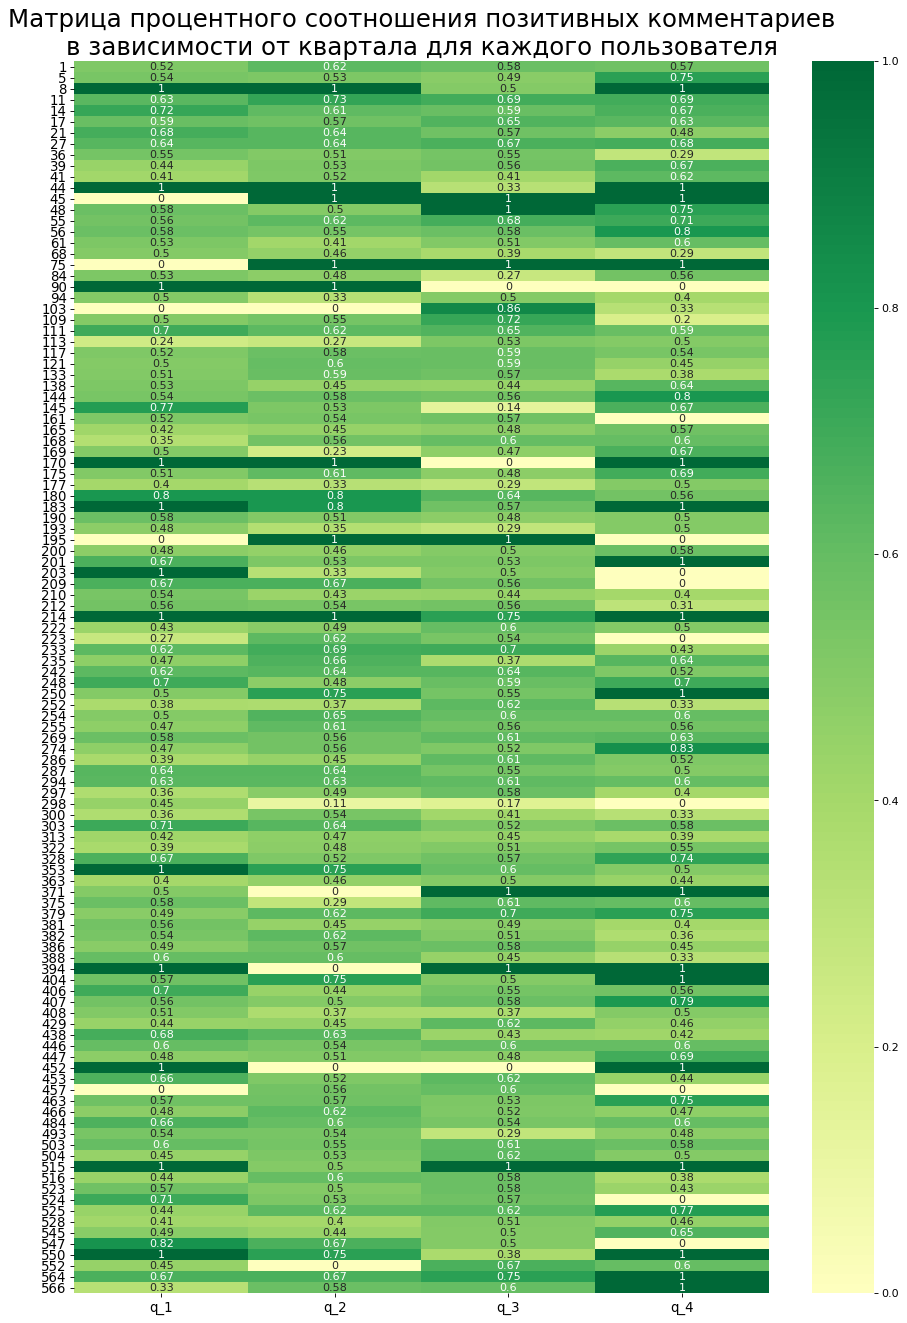

In [385]:
plt.rcParams['font.size'] = 10

plt.figure(figsize=(14,20), dpi= 80)
sns.heatmap(dif_matrix, xticklabels=dif_matrix.columns, yticklabels=dif_matrix.index, cmap='RdYlGn', center=0, annot=True)

plt.title('Матрица процентного соотношения позитивных комментариев\nв зависимости от квартала для каждого пользователя', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()